### Cargar Datos e importar librerias

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import math
import seaborn as sns

# Cargar los datos
file_path = "trafico_gijon.csv"
df = pd.read_csv(file_path)

### Mostrar datos

In [2]:
df.head()

,street,latitude,longitude,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,confidence,roadClosure
0,Camino de Santurio,43.496492,-5.636755,35,35,143,143,1.000000,False
1,Camín de Los Acebos,43.486226,-5.703471,38,38,282,282,1.000000,False
2,Calle Oscar Olavarría,43.546253,-5.664720,21,26,290,234,0.963129,False
3,Camín de La Frontera,43.479580,-5.744609,69,69,16,16,1.000000,False
4,Calle Doctor Bellmunt,43.536668,-5.657570,26,34,522,399,0.995637,False


### Datos estadísticos e información

In [3]:
print(df.columns)
print(df.shape)
print(df.index)
print(df.info())
df.describe()

Index(['street', 'latitude', 'longitude', 'currentSpeed', 'freeFlowSpeed',
       'currentTravelTime', 'freeFlowTravelTime', 'confidence', 'roadClosure'],
      dtype='object')
(1841, 9)
RangeIndex(start=0, stop=1841, step=1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1841 entries, 0 to 1840
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              1841 non-null   object 
 1   latitude            1841 non-null   float64
 2   longitude           1841 non-null   float64
 3   currentSpeed        1841 non-null   int64  
 4   freeFlowSpeed       1841 non-null   int64  
 5   currentTravelTime   1841 non-null   int64  
 6   freeFlowTravelTime  1841 non-null   int64  
 7   confidence          1841 non-null   float64
 8   roadClosure         1841 non-null   bool   
dtypes: bool(1), float64(3), int64(4), object(1)
memory usage: 117.0+ KB
None


,latitude,longitude,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,confidence
count,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000,1841.000000
mean,42.167312,-7.794181,49.036936,50.629549,541.548615,518.892993,0.991214
std,7.984914,13.621152,26.936212,25.525109,443.270435,449.831443,0.036028
min,-37.843099,-122.116574,8.000000,8.000000,2.000000,2.000000,0.537827
25%,43.486811,-5.703471,28.000000,31.000000,223.000000,209.000000,1.000000
50%,43.525067,-5.669549,44.000000,44.000000,462.000000,367.000000,1.000000
75%,43.537759,-5.649064,56.000000,56.000000,640.000000,640.000000,1.000000
max,47.864133,26.112699,123.000000,123.000000,2220.000000,2220.000000,1.000000


### Análisis Univariante

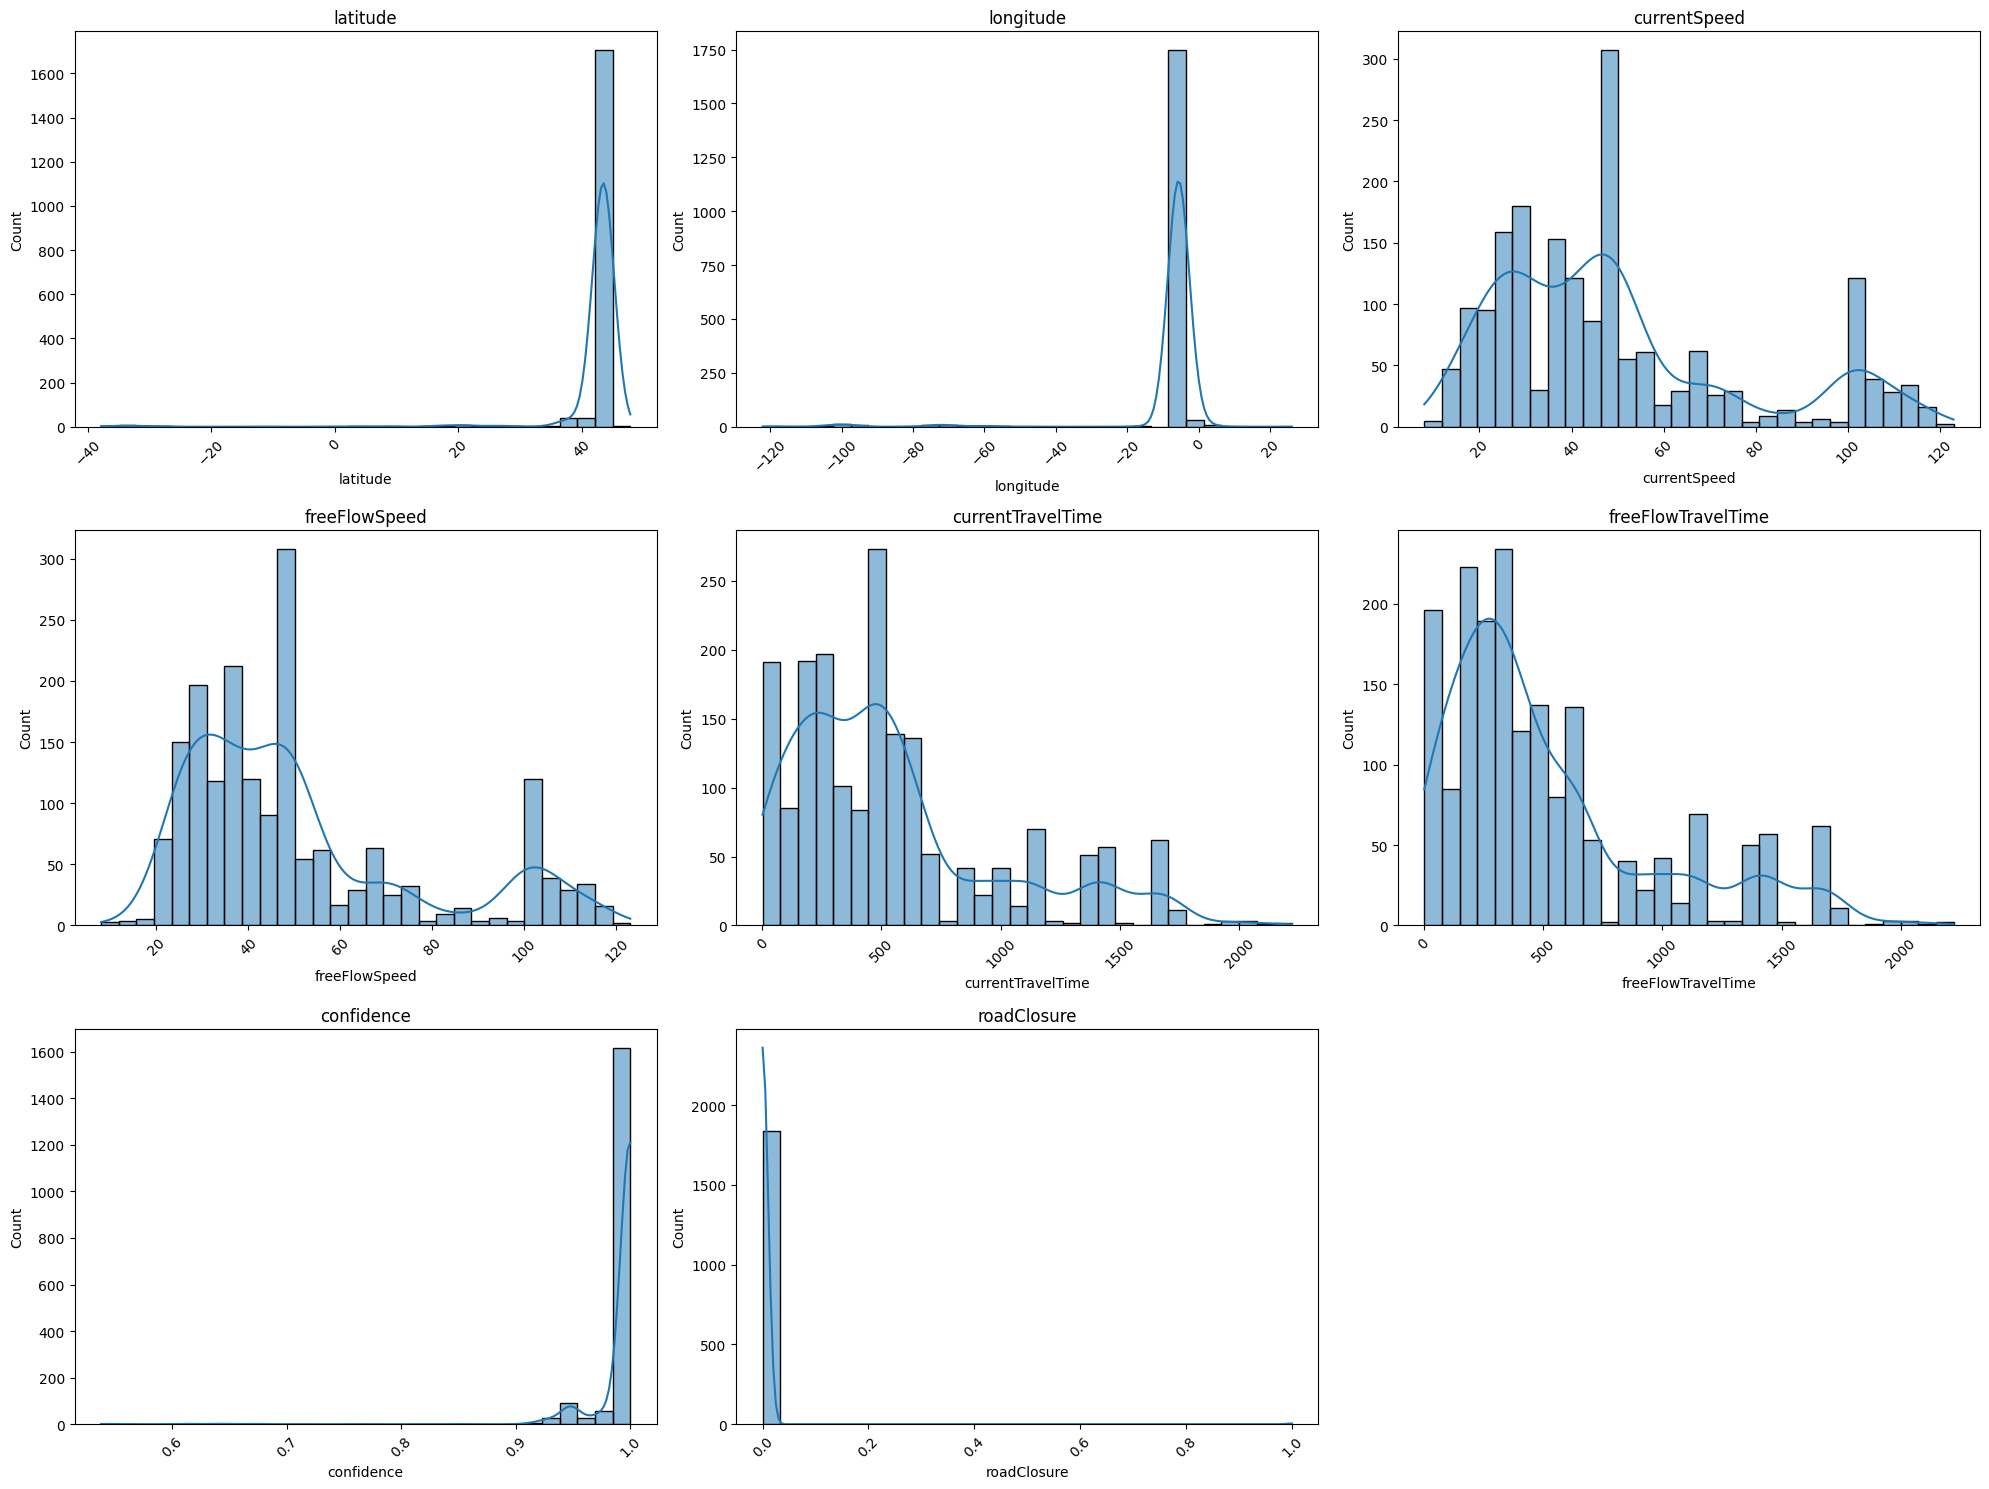

In [ ]:
def analisis_univariante(data, cols=3, width=20, height=15):
    fig = plt.figure(figsize=(width, height))
    rows = math.ceil((data.shape[1] - 1) / cols)
    plot_index = 1

    for column in data.columns:
        if column == 'street':
            continue  # Saltar columna

        ax = fig.add_subplot(rows, cols, plot_index)
        plot_index += 1
        ax.set_title(column)

        if data[column].dtype == 'object':
            top_categories = data[column].value_counts().index[:10]
            sns.countplot(data=data[data[column].isin(top_categories)],
                          y=column,
                          ax=ax,
                          palette='viridis',
                          order=top_categories)
            plt.xticks(rotation=45)
        else:
            sns.histplot(data[column], ax=ax, kde=True, bins=30)
            plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Llamar a la función con el DataFrame existente
analisis_univariante(df)

### Comparar Velocidad de Vía con Velocidad del tráfico

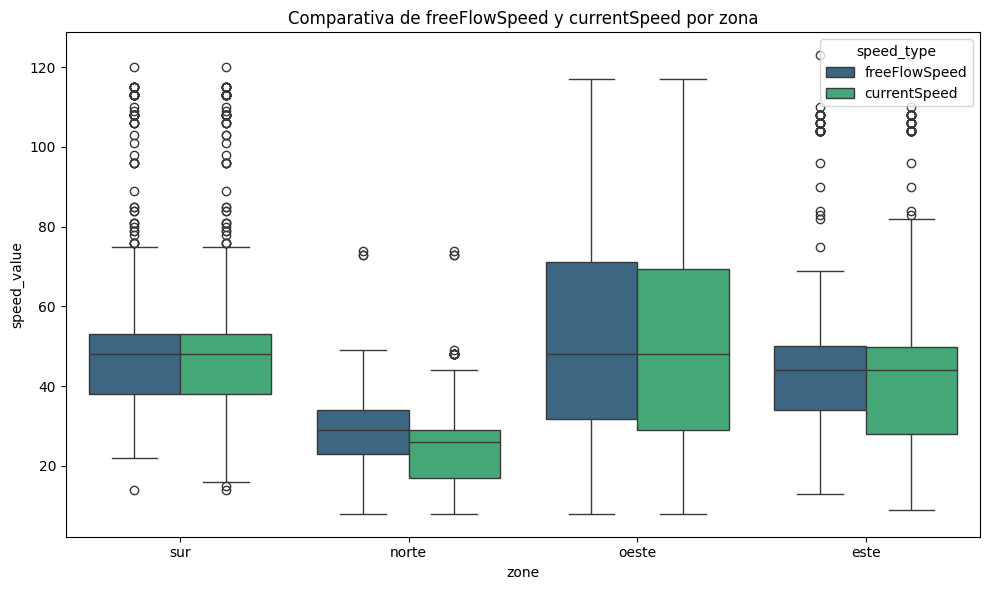

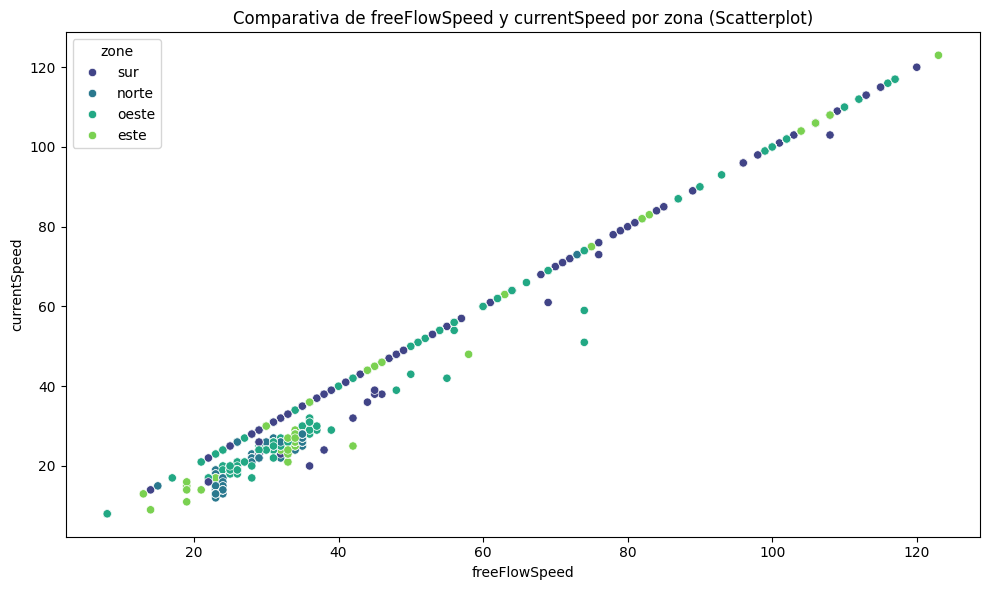

In [27]:
def get_zone(lat, lon, center_lat=43.53, center_lon=-5.66):
    lat_diff = lat - center_lat
    lon_diff = lon - center_lon
    # Asignamos la zona según la componente con mayor diferencia
    if abs(lat_diff) > abs(lon_diff):
        return "norte" if lat_diff > 0 else "sur"
    else:
        return "este" if lon_diff > 0 else "oeste"

# Cargar CSV
df = pd.read_csv("trafico_gijon.csv")

# Crear la columna 'zone'
df["zone"] = df.apply(lambda row: get_zone(row["latitude"], row["longitude"]), axis=1)

# Unir (melt) las columnas de velocidad para compararlas en un mismo gráfico
df_melted = df.melt(id_vars=["zone"], 
                    value_vars=["freeFlowSpeed", "currentSpeed"], 
                    var_name="speed_type", 
                    value_name="speed_value")

# Graficar diagrama de cajas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x="zone", y="speed_value", hue="speed_type", palette="viridis")
plt.title("Comparativa de freeFlowSpeed y currentSpeed por zona")
plt.tight_layout()
plt.show()

# Scatterplot comparando freeFlowSpeed y currentSpeed, coloreado por zona
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="freeFlowSpeed", y="currentSpeed", hue="zone", palette="viridis")
plt.title("Comparativa de freeFlowSpeed y currentSpeed por zona (Scatterplot)")
plt.tight_layout()
plt.show()

### Comparar tiempo de viaje normal y actual

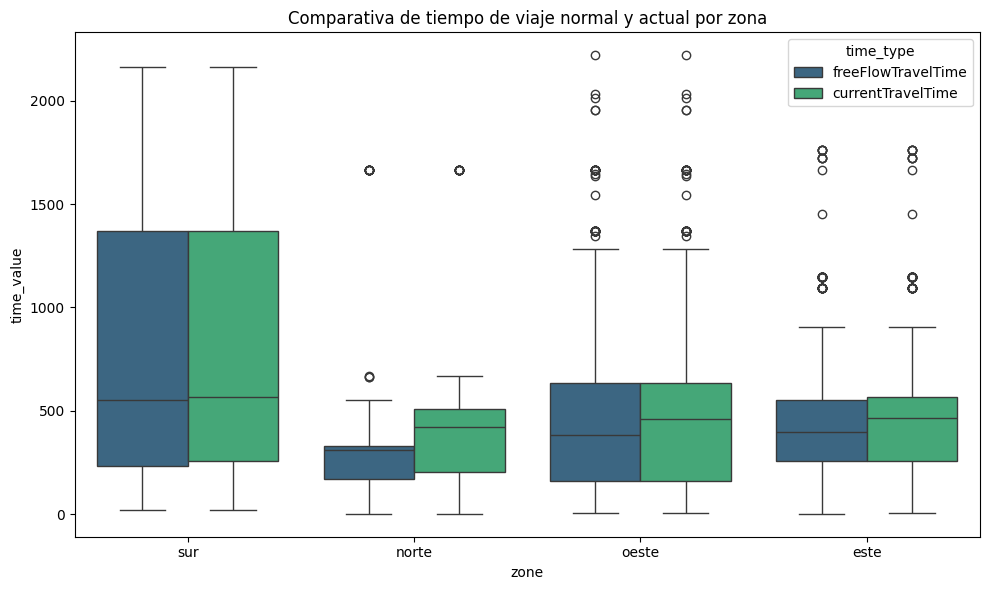

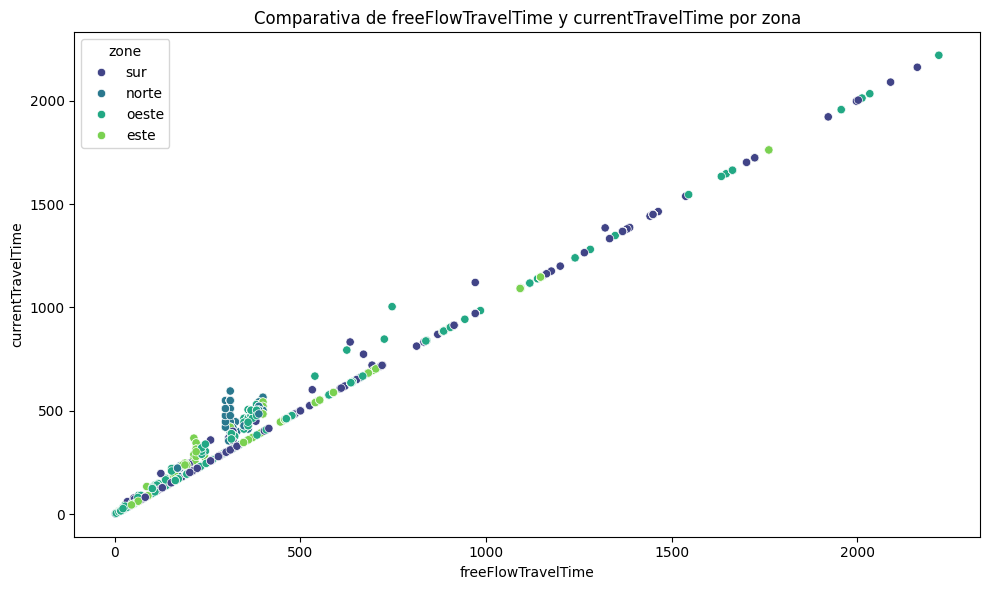

In [30]:
def get_zone(lat, lon, center_lat=43.53, center_lon=-5.66):
    lat_diff = lat - center_lat
    lon_diff = lon - center_lon
    # Asignamos la zona según la componente con mayor diferencia
    if abs(lat_diff) > abs(lon_diff):
        return "norte" if lat_diff > 0 else "sur"
    else:
        return "este" if lon_diff > 0 else "oeste"

# Cargar CSV
df = pd.read_csv("trafico_gijon.csv")

# Crear la columna 'zone'
df["zone"] = df.apply(lambda row: get_zone(row["latitude"], row["longitude"]), axis=1)

# Unir (melt) las columnas de tiempo para compararlas en un mismo gráfico
df_melted = df.melt(id_vars=["zone"], 
                    value_vars=["freeFlowTravelTime", "currentTravelTime"], 
                    var_name="time_type", 
                    value_name="time_value")

# Graficar diagrama de cajas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x="zone", y="time_value", hue="time_type", palette="viridis")
plt.title("Comparativa de tiempo de viaje normal y actual por zona")
plt.tight_layout()
plt.show()

# Scatterplot comparando freeFlowSpeed y currentSpeed, coloreado por zona
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="freeFlowTravelTime", y="currentTravelTime", hue="zone", palette="viridis")
plt.title("Comparativa de freeFlowTravelTime y currentTravelTime por zona")
plt.tight_layout()
plt.show()

### Comparar Velocidad y tiempo

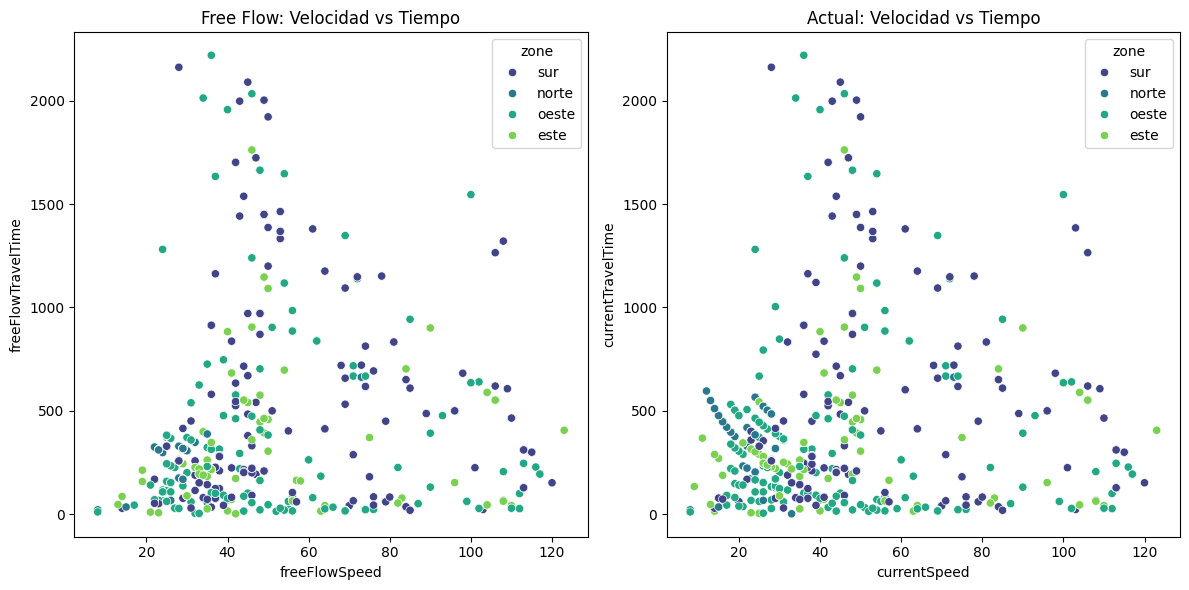

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_zone(lat, lon, center_lat=43.53, center_lon=-5.66):
    lat_diff = lat - center_lat
    lon_diff = lon - center_lon
    if abs(lat_diff) > abs(lon_diff):
        return "norte" if lat_diff > 0 else "sur"
    else:
        return "este" if lon_diff > 0 else "oeste"

df = pd.read_csv("trafico_gijon.csv")

df["zone"] = df.apply(lambda row: get_zone(row["latitude"], row["longitude"]), axis=1)

plt.figure(figsize=(12, 6))

# Subplot 1: Free flow
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x="freeFlowSpeed", y="freeFlowTravelTime", hue="zone", palette="viridis")
plt.title("Free Flow: Velocidad vs Tiempo")

# Subplot 2: Actual
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x="currentSpeed", y="currentTravelTime", hue="zone", palette="viridis")
plt.title("Actual: Velocidad vs Tiempo")

plt.tight_layout()
plt.show()

### Agrupar calles similares con clustering

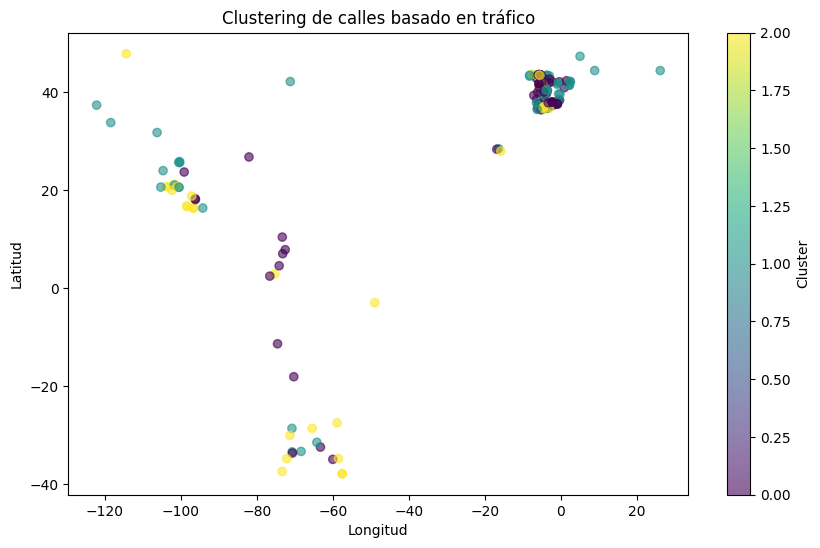

In [4]:
# Seleccionar columnas relevantes para clustering
X = df[['latitude', 'longitude', 'currentSpeed', 'freeFlowSpeed', 'currentTravelTime', 'freeFlowTravelTime']]

# Aplicar K-Means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

# Visualizar los clusters en un mapa de dispersión
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Clustering de calles basado en tráfico")
plt.show()

### Aplicar PCA para reducir dimensiones

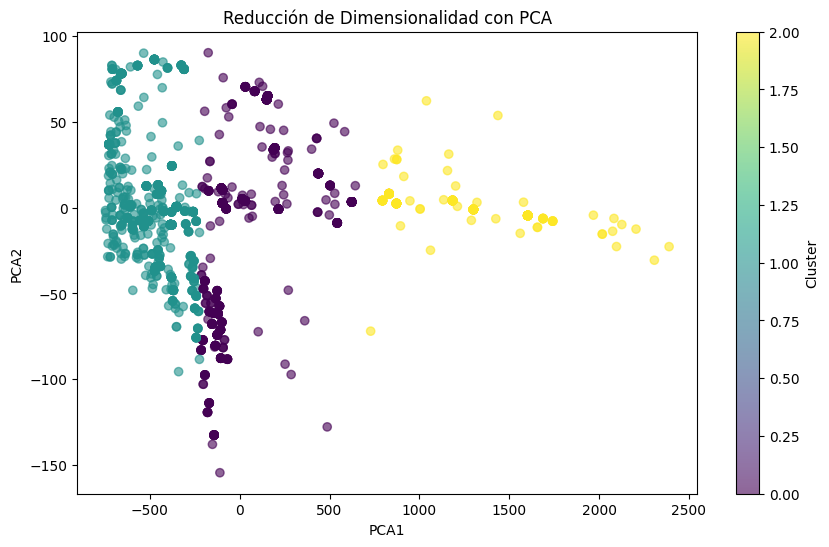

In [5]:
# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Agregar los componentes principales al DataFrame
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Visualizar en un gráfico de dispersión
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Reducción de Dimensionalidad con PCA")
plt.show()

### Detectar Anomalías con IsolationForest

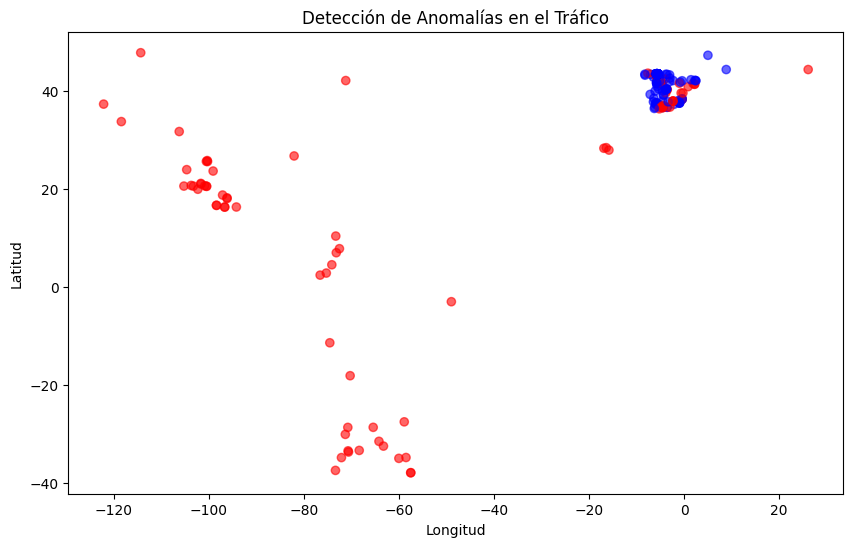

In [6]:
# Aplicar Isolation Forest para detección de anomalías
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso_forest.fit_predict(X)

# Mapear los valores (-1 = anomalía, 1 = normal) a colores
df['anomaly_color'] = df['anomaly'].map({1: 'blue', -1: 'red'})

# Visualizar anomalías en un mapa de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['anomaly_color'], alpha=0.6)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Detección de Anomalías en el Tráfico")
plt.show()

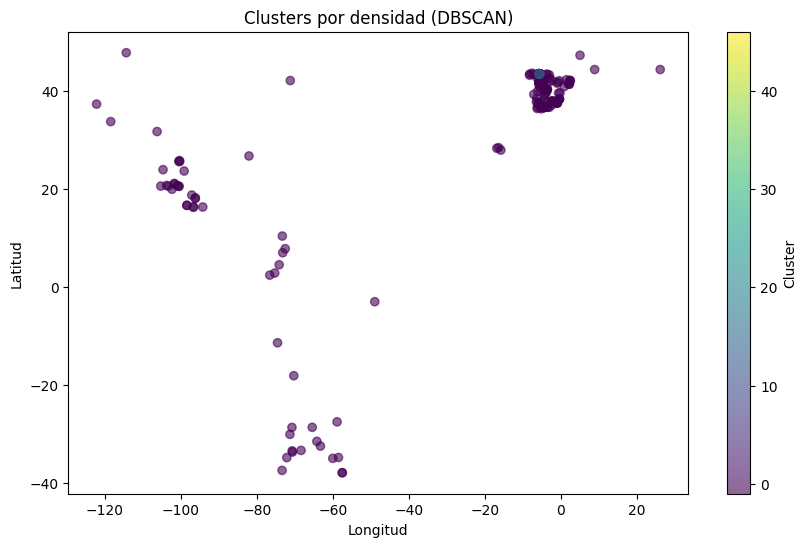

In [7]:
# Nuevas importaciones
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score

# 1. Análisis de densidad con DBSCAN
dbscan = DBSCAN(eps=0.02, min_samples=10)
df['dbscan_cluster'] = dbscan.fit_predict(X)

# Visualización DBSCAN
plt.figure(figsize=(10,6))
plt.scatter(df['longitude'], df['latitude'], c=df['dbscan_cluster'], cmap='viridis', alpha=0.6)
plt.title("Clusters por densidad (DBSCAN)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.colorbar(label="Cluster")
plt.show()

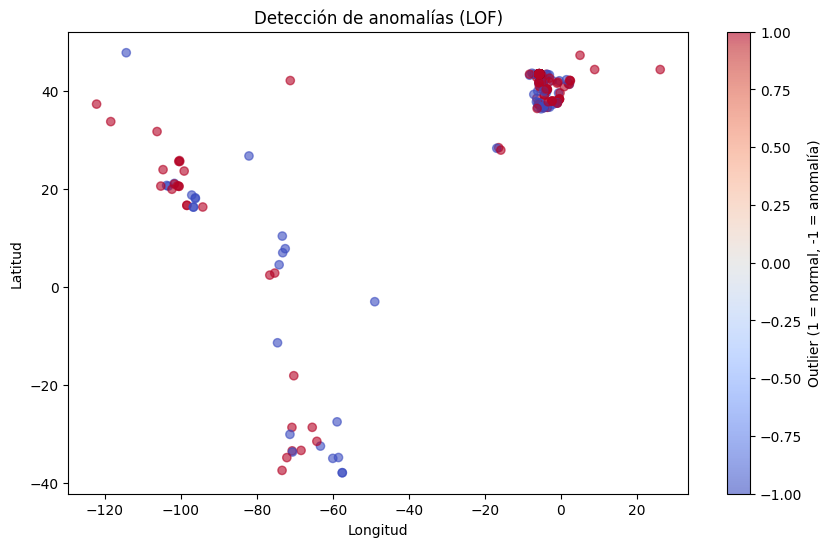

In [8]:
# 2. Detección de anomalías con Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
df['is_outlier'] = lof.fit_predict(X)

# Visualización anomalías
plt.figure(figsize=(10,6))
plt.scatter(df['longitude'], df['latitude'], c=df['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.title("Detección de anomalías (LOF)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.colorbar(label="Outlier (1 = normal, -1 = anomalía)")
plt.show()

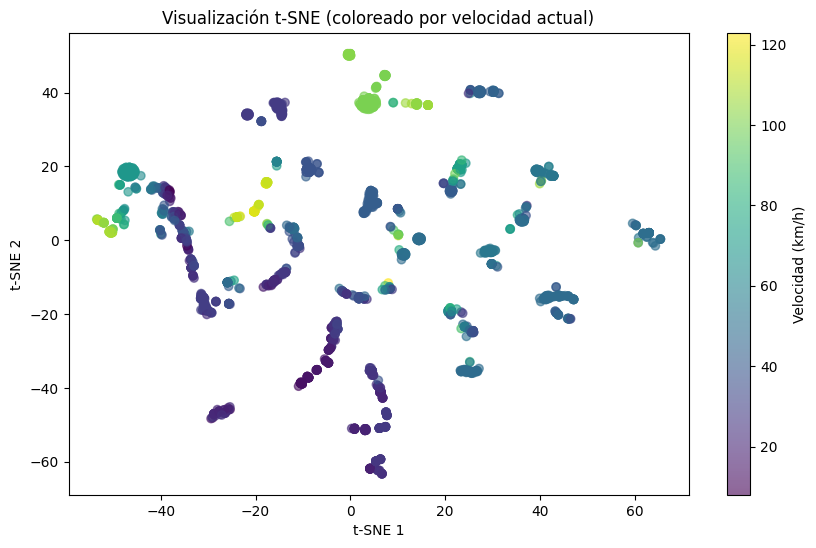

In [9]:
# 3. Visualización con t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df['currentSpeed'], cmap='viridis', alpha=0.6)
plt.title("Visualización t-SNE (coloreado por velocidad actual)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="Velocidad (km/h)")
plt.show()

In [10]:
# 4. Validación de clusters (K-Means)
print("\nMétricas de evaluación:")
print(f"Silhouette Score (K-Means): {silhouette_score(X, df['cluster']):.2f}")


Métricas de evaluación:
Silhouette Score (K-Means): 0.56


### Mapa de tráfico en Gijón

In [13]:
import pandas as pd
import folium

# Carga el CSV
df = pd.read_csv("trafico_gijon.csv")

# Función para asignar color según nivel de tráfico (velocidad actual / velocidad libre)
def get_color_ratio(speed, free_speed):
    ratio = speed / free_speed if free_speed else 0
    if ratio < 0.5:
        return "red"
    elif ratio < 0.8:
        return "orange"
    else:
        return "green"

# Crea el mapa centrado aproximadamente en Gijón
mapa = folium.Map(location=[43.53, -5.66], zoom_start=12)

# Agrega marcadores con colores según tráfico y marcadores especiales para calles cerradas
for _, row in df.iterrows():
    if row["roadClosure"]:
        color = "black"
    else:
        color = get_color_ratio(row["currentSpeed"], row["freeFlowSpeed"])
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        popup=row["street"]
    ).add_to(mapa)

# Guarda el resultado
mapa.save("mapa_trafico_gijon.html")
mapa